In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from tensorflow.keras.datasets import fashion_mnist


In [3]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Normalize from from 0 to 255 to [0, 1]
train_images = train_images / 255.0
test_images = test_images / 255.0

In [5]:
# Convert 2D images (28x28 pixels) into 1D vectors (784 values)
train_flat = train_images.reshape(len(train_images), -1)  # shape: (60000, 784)
test_flat = test_images.reshape(len(test_images), -1)    # shape: (10000, 784)

In [8]:
# Check the Result
print("Shape before flattening:", train_images.shape)  # (60000, 28, 28)
print("Shape after flattening:", train_flat.shape)     # (60000, 784)

print("Pixel range:", train_images.min(), "to", train_images.max())

Shape before flattening: (60000, 28, 28)
Shape after flattening: (60000, 784)
Pixel range: 0.0 to 1.0


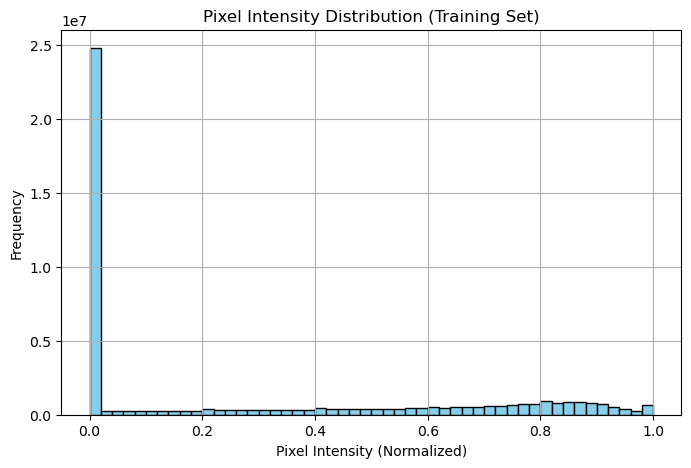

In [ ]:
# Flatten all training pixels into a 1D array
all_pixels = train_images.flatten()

# Plot histogram of pixel values to understand how grayscale intensities (0 to 255 → now scaled 0 to 1) are distributed across the dataset.
plt.figure(figsize=(8, 5))
plt.hist(all_pixels, bins=50, color='skyblue', edgecolor='black')
plt.title("Pixel Intensity Distribution (Training Set)")
plt.xlabel("Pixel Intensity (Normalized)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

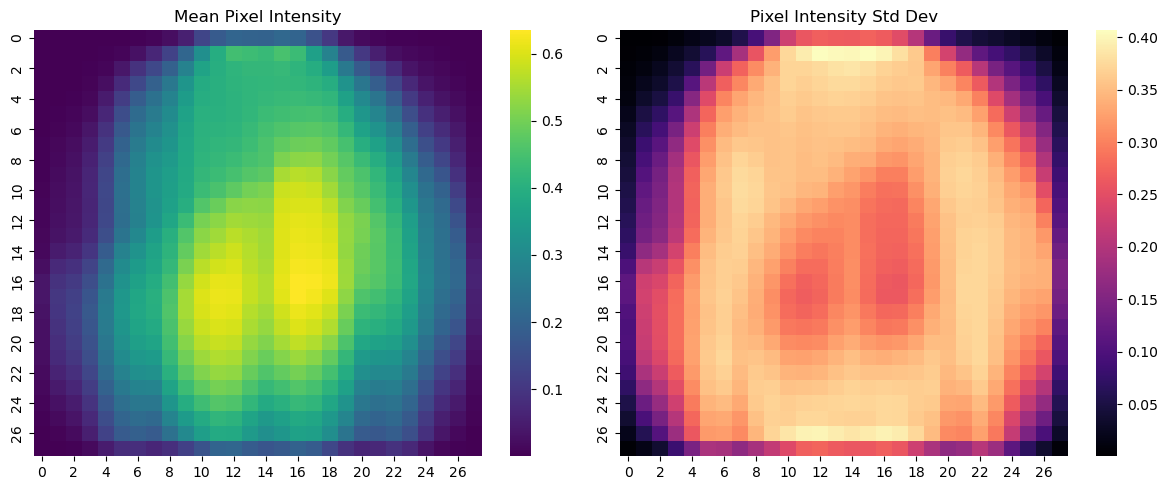

In [ ]:
# Mean and std of each pixel across all training images
pixel_mean = np.mean(train_images, axis=0)
pixel_std = np.std(train_images, axis=0)

# Plot heatmaps shows how much variation each pixel has across all images — useful for understanding structure in the image layout.
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(pixel_mean, ax=axs[0], cmap='viridis')
axs[0].set_title("Mean Pixel Intensity")
sns.heatmap(pixel_std, ax=axs[1], cmap='magma')
axs[1].set_title("Pixel Intensity Std Dev")
plt.tight_layout()
plt.show()

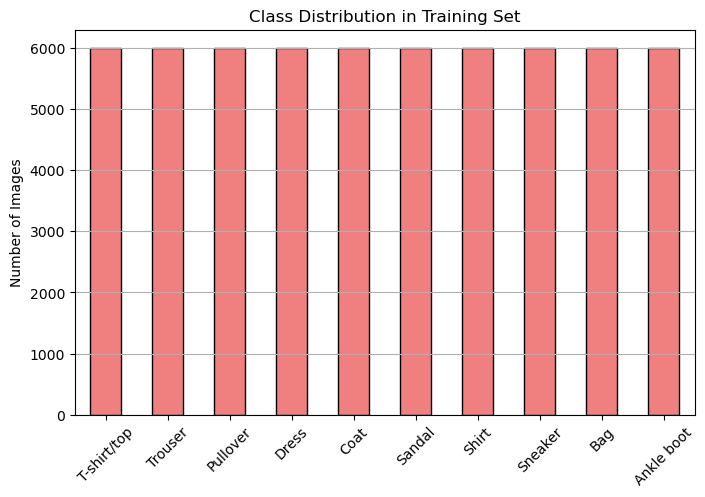

In [15]:
# Class names mapping
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Create a DataFrame for counts
label_counts = pd.Series(train_labels).value_counts().sort_index()
label_counts.index = class_names

# Plot
plt.figure(figsize=(8, 5))
label_counts.plot(kind='bar', color='lightcoral', edgecolor='black')
plt.title("Class Distribution in Training Set")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

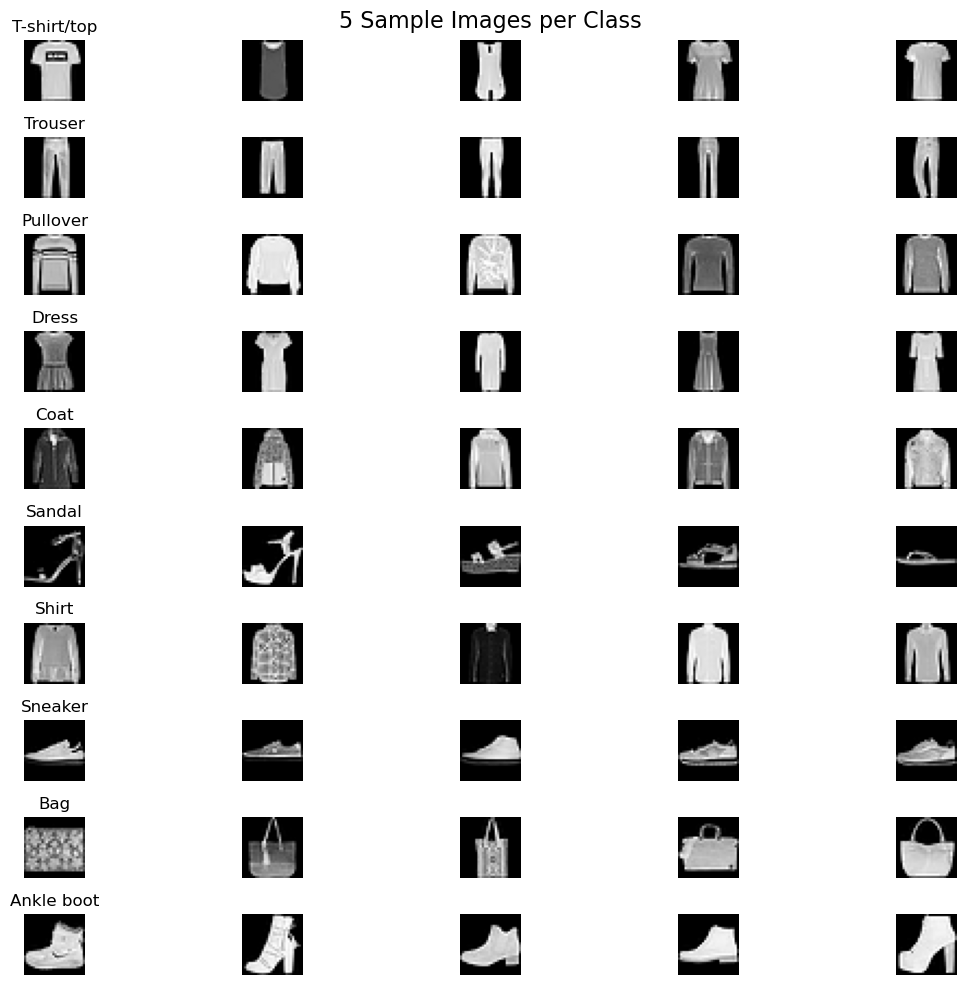

In [17]:
# Plot 5 samples per class
plt.figure(figsize=(12, 10))

for label in range(10):
    # Get indexes of images with this label
    idxs = np.where(train_labels == label)[0][:5]
    
    for i, idx in enumerate(idxs):
        plt_idx = label * 5 + i + 1
        plt.subplot(10, 5, plt_idx)
        plt.imshow(train_images[idx], cmap="gray")
        plt.axis("off")
        
        if i == 0:
            plt.title(class_names[label])

plt.suptitle("5 Sample Images per Class", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

In [18]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Flattened data assumed from earlier step
# train_flat shape: (60000, 784)

# Apply PCA without specifying n_components (keep all to analyze variance)
pca = PCA()
pca.fit(train_flat)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

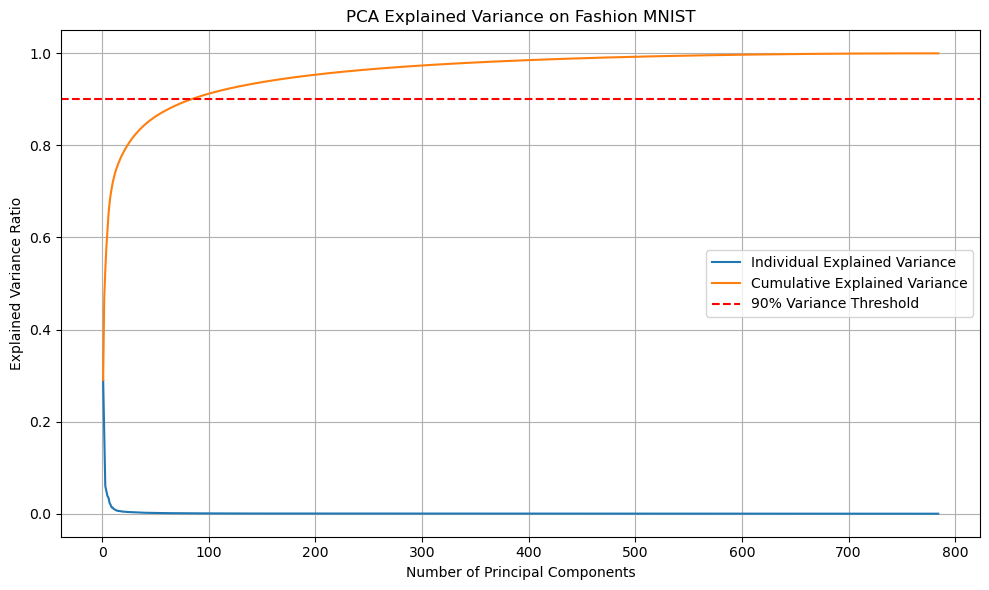

In [19]:
plt.figure(figsize=(10, 6))

# Explained variance per component
plt.plot(range(1, len(explained_variance) + 1), explained_variance, label="Individual Explained Variance")

# Cumulative variance
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, label="Cumulative Explained Variance")

plt.axhline(y=0.90, color='r', linestyle='--', label="90% Variance Threshold")
plt.title("PCA Explained Variance on Fashion MNIST")
plt.xlabel("Number of Principal Components")
plt.ylabel("Explained Variance Ratio")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [22]:
from sklearn.metrics import mean_squared_error

def reconstruct_and_evaluate(train_flat, n_components_list):
    mse_results = {}
    reconstructions = {}

    for n in n_components_list:
        # Fit PCA and transform
        pca = PCA(n_components=n)
        train_reduced = pca.fit_transform(train_flat)
        
        # Reconstruct images
        train_reconstructed = pca.inverse_transform(train_reduced)
        
        # Calculate MSE between original and reconstructed
        mse = mean_squared_error(train_flat, train_reconstructed)
        mse_results[n] = mse
        reconstructions[n] = train_reconstructed

        print(f"{n} components → MSE: {mse:.5f}")

    return mse_results, reconstructions

n_components_list = [10, 50, 100]
mse_results, reconstructions = reconstruct_and_evaluate(train_flat, n_components_list)



10 components → MSE: 0.02437
50 components → MSE: 0.01195
100 components → MSE: 0.00763


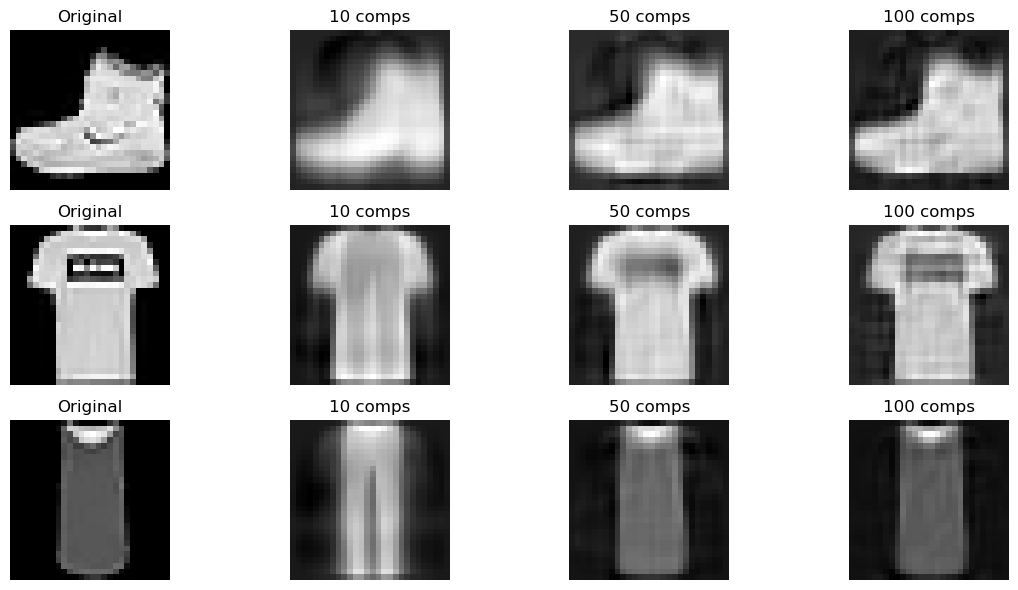

In [23]:
import matplotlib.pyplot as plt

def show_reconstruction_comparison(originals, reconstructions, indices=[0, 1, 2]):
    plt.figure(figsize=(12, len(indices) * 2))

    for row, idx in enumerate(indices):
        # Original
        plt.subplot(len(indices), len(reconstructions) + 1, row * (len(reconstructions) + 1) + 1)
        plt.imshow(originals[idx].reshape(28, 28), cmap='gray')
        plt.title("Original")
        plt.axis('off')

        # Reconstructions
        for col, n in enumerate(sorted(reconstructions.keys())):
            plt.subplot(len(indices), len(reconstructions) + 1, row * (len(reconstructions) + 1) + 2 + col)
            plt.imshow(reconstructions[n][idx].reshape(28, 28), cmap='gray')
            plt.title(f"{n} comps")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

show_reconstruction_comparison(train_flat, reconstructions)


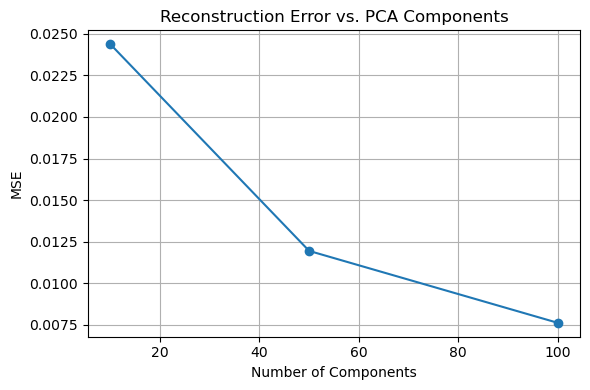

In [24]:
plt.figure(figsize=(6, 4))
plt.plot(mse_results.keys(), mse_results.values(), marker='o')
plt.title("Reconstruction Error vs. PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("MSE")
plt.grid(True)
plt.tight_layout()
plt.show()
